# Exercise 2 - Baby Names in NY

The basis of this exercise is to analyze the distribution of the newborn babies' names across the different counties of the NY State, as well as their origins and their relationship between the counties and the whole data of the NY State.

To perform this analysis we are going to use mostly visual data commented, but the data is easily accessed as Pandas' DataFrame in case the reader wants to check it in a tabular form too.

We will start by loading and preparing the data, later on we will explore the main questions presented in the exercise considering the state of NY as a single data source, and after that we will deep dive into the data differentiating counties, and looking for some key answers such as which is the most representative county. Finally, we will report our main insights, answering some of the questions we've been introducing and suggesting possible next steps depending on our strategies.

## Imports needed

In [1]:
import warnings
import json
from urllib.request import urlopen
from PIL import Image
import IPython
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
%matplotlib inline

Functions definded to ease our work while plotting:

In [2]:
def get_choropleth_categories(df: pd.DataFrame, category: str, title: str, fips: str='FIPS') -> plotly.graph_objs._figure.Figure:
    """ Returns a plotly figure with a choropleth map representing categories (1 color per category value)
    
    :param df: DF to plot our map
    :param category: Name of the category to plot in the map
    :param title: Title of the map
    :param fips: Name of the column with the FIPS code to plot our map
    :return: Plotly figure with geolocation data
    """
    
    # Getting values and locations to plot
    values = df[category].tolist()
    fips = df[fips].tolist()

    # Creating Map
    fig = ff.create_choropleth(
        fips=fips, values=values, scope=['New York'], show_state_data=True,
        round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=title,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=True,
    )
    fig.layout.template = None
    
    return fig


def get_choropleth_numerical(df: pd.DataFrame, numerical: str, title: str, fips: str='FIPS') -> plotly.graph_objs._figure.Figure:
    """ Returns a plotly figure with a choropleth map representing numerical values (color scale per value)
    
    :param df: DF to plot our map
    :param numerical: Name of the column with the numerical values to plot in the map
    :param title: Title of the map
    :param fips: Name of the column with the FIPS code to plot our map
    :return: Plotly figure with geolocation data
    """
    
    # Getting values and locations to plot
    values = df[numerical].tolist()
    fips = df[fips].tolist()


    endpts = list(np.mgrid[min(values):max(values):4j])
    colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
                  "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
    # Creating Map
    fig = ff.create_choropleth(
        fips=fips, values=values, scope=['New York'], show_state_data=True,
        colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=title,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=True,
    )
    fig.layout.template = None
    
    return fig

## Data loading 

There are 2 files concerning this exercise, being both useful to pursue the target proposed on the instructions. Therefore, we are going to load both files as Pandas' dataframes to operate with them easily:

In [3]:
baby_names = pd.read_csv('../data/Baby_Names__Beginning_2007.csv')

In [4]:
# Ensure data has been loaded correctly
baby_names.head()

Year First Name       County Sex  Count
0  2012    DOMINIC       CAYUGA   M      6
1  2012    ADDISON     ONONDAGA   F     14
2  2012      JULIA     ONONDAGA   F     15
3  2012    WILLIAM  WESTCHESTER   M     41
4  2012     AMELIA     ONONDAGA   F     15

In [5]:
names_origins = pd.read_csv('../data/Names_Origins.csv', sep=';')

In [6]:
# Ensure data has been loaded correctly
names_origins.head()

First Name   Origin  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0      AADEN  African         NaN         NaN         NaN         NaN   
1    AALIYAH  Russian         NaN         NaN         NaN         NaN   
2      AARON    Norse         NaN         NaN         NaN         NaN   
3      AAYAN    Latin         NaN         NaN         NaN         NaN   
4       ABBY   Korean         NaN         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN

It may seem that the first file has been loaded correctly, but the second one has some extra columns without header or actual values inside them. We may now check the presence of NAs inside the DataFrame and decide how to deal with them:

In [7]:
# Getting % of total entries
names_origins.isna().sum() / names_origins.shape[0]

First Name    0.0
Origin        0.0
Unnamed: 2    1.0
Unnamed: 3    1.0
Unnamed: 4    1.0
Unnamed: 5    1.0
Unnamed: 6    1.0
Unnamed: 7    1.0
Unnamed: 8    1.0
dtype: float64

As it seemed during the loading, extra `;` characters inside the `Names_Origins.csv` file made Pandas create columns which in fact should not exist. **We could at this point change our previous code to avoid the loading of these extra columns in the first place**, but as this is taken as an exercise what I would do is to drop them now:

In [8]:
# Dropping void columns
names_origins = names_origins.iloc[:, :2]
# Showing the result
names_origins.head()

First Name   Origin
0      AADEN  African
1    AALIYAH  Russian
2      AARON    Norse
3      AAYAN    Latin
4       ABBY   Korean

## Dataset Merging

To better work with a single source of information and correlate the ocurrence of the names inside the different years and counties and their origins, we are going to perform a merge on the `First Name` column of both files:

In [9]:
baby_name_merged = baby_names.merge(names_origins,
                                    how='left',
                                    on='First Name')
baby_name_merged.head()

Year First Name       County Sex  Count            Origin
0  2012    DOMINIC       CAYUGA   M      6           Chinese
1  2012    ADDISON     ONONDAGA   F     14  African American
2  2012      JULIA     ONONDAGA   F     15           English
3  2012    WILLIAM  WESTCHESTER   M     41           Italian
4  2012     AMELIA     ONONDAGA   F     15          Hawaiian

## Data Profiling

I allowed myself to use a tool that I particularly like, which is `ProfileReport` from the `pandas_profiling` package.
This tool present us a more detailed description of our dataset, so it substitutes methods like `.info()` or `.describe()` presenting a more user-friendly interface. Besides, it provides some basic aggregation functions to the different columns, so we may now the ocurrence of its value inside each column, the number of NAs or the number of duplicate rows with some very simple actions. Furthermore, it presents basic correlations between the different variables.

In [10]:
profile_report = ProfileReport(baby_name_merged)
profile_report

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The main drawback of this tool comes with the enormous amount of information that it is given, as it requires some exploration to show its true potential. So, in the end its capabilities depend on the analyst that reads the report more than on the one that writes the code. For this reason I will explain the most important points that we may obtain from this report:
- There are 2 numerical columns (Year and Count) and 4 Categorical (First Name, County, Sex and Origin).
- There are no missing rows, therefore every name has its origin identified and our merge has been 100% succesful.
- There are 1559 distinct names present on our dataset, 51 different origins and 61 counties, which mean 1 county is not present on the dataset ([there are 62](https://en.wikipedia.org/wiki/List_of_counties_in_New_York)).
- During the years, a similar number of combinations of different names/counties has been maintained, except in 2010 where it got reduced abruptely. We may also see in the `Interactions` section that the presence of rare names got reduced on that year (less frequence of lower count entries).
- Male names have a set more diverse than female names across the different county/year combinations (18.7k combinations again 16.5k).
- Jacob, Emma, Logan, Olivia and Isabella are the most widespread names in space and time, meaning that they have the most county/year combinations (although we do not know yet if they are the most common, as we are only seeing combinations here and not counts).

## Outliers Check

After reviewing our report we noticed that there are some observations inside the `Count` column that may be treated as outliers. This could be normal due to counties much more populated than others, or names being much more populated than others on a certain space and time, but we may take a look to assert the severeness of our problem:

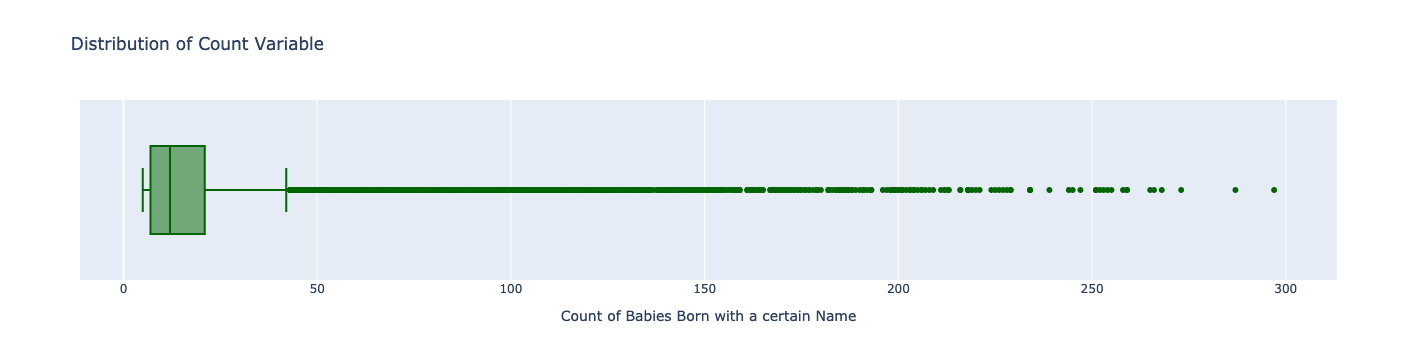

In [11]:
fig0 = px.box(x=baby_name_merged.Count, color_discrete_sequence=['darkgreen'],
              title='Distribution of Count Variable')
fig0.update_xaxes(title='Count of Babies Born with a certain Name')

We see that there are several points outside the IQR, and therefore should be considered outliers. On a Machine Learning problem we should decide how to proceed with them, for instance dropping them of choosing a higher level of aggregation (if our problem allows that) to smooth the distribution. Nevertheless, as we only want to draw conclusions from this analysis we will let them as they are.

## Exploratory Data Analysis

### Analysis at State Level

#### Gender Distribution

One of the main things to consider is how the gender distribution applies the NY State, using both absolute and relative numbers to get the main idea behind how the genders are distributed through newborns:

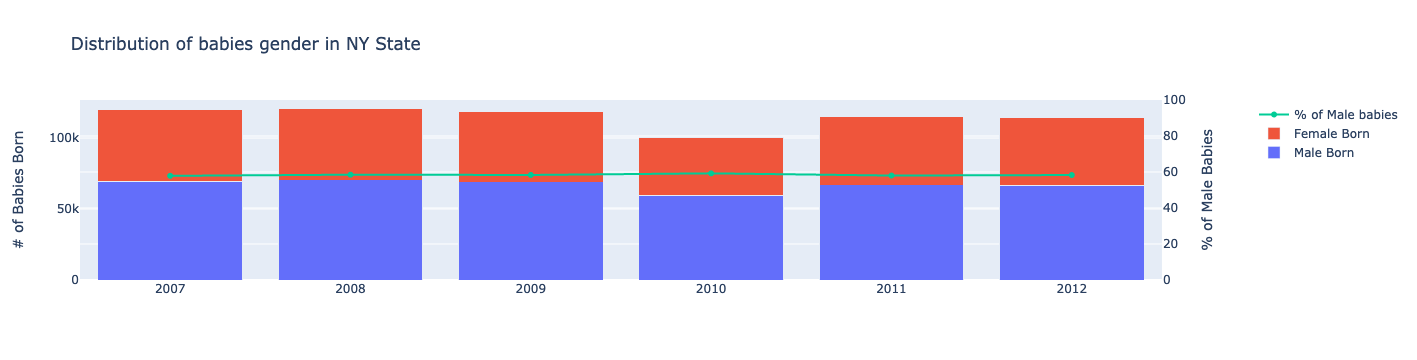

In [12]:
# Grouping data by sex and year and calculating male %
grouped_year_sex = baby_name_merged.groupby(['Year', 'Sex']).sum().unstack()
grouped_year_sex['Male %'] = grouped_year_sex[('Count', 'M')] / grouped_year_sex.sum(axis=1) * 100

# Plotting the results
fig1 = make_subplots(specs=[[{"secondary_y": True}]])

fig1.add_trace(
    go.Bar(x=grouped_year_sex.index, y=grouped_year_sex[('Count', 'M')], name='Male Born')
)
fig1.add_trace(
    go.Bar(x=grouped_year_sex.index, y=grouped_year_sex[('Count', 'F')], name='Female Born')
)
fig1.add_trace(
    go.Scatter(x=grouped_year_sex.index, y=grouped_year_sex['Male %'], name='% of Male babies'),
    secondary_y=True
)
fig1.update_yaxes(title_text="# of Babies Born", secondary_y=False)
fig1.update_yaxes(title_text="% of Male Babies", secondary_y=True, range=[0,100])
fig1.update_layout(barmode='stack',
                   title='Distribution of babies gender in NY State')

As we may see, the # of babies born was around 120K every year before 2010, when the births dropped bellow 100K. This may be explained by the [great insecurity that the NY State was under 2009](https://fiscalpolicy.org/state-of-working-new-york-2009) due to the subprime crisis. Nevertheless, we see these numbers recover to above 115K on 2011 and 2012, as the economy grew stronger.

Regarding the % of Male births out of the total, we see that the male babies are more numerous, on a proportion of 116/100 male to female births, which is a little bit superior to the US average according to the following graph of [Our World in Data](https://ourworldindata.org/gender-ratio) (all credit to them).

In [13]:
iframe = '<iframe src="https://ourworldindata.org/grapher/sex-ratio-at-birth?tab=chart&country=~USA" loading="lazy" style="width: 100%; height: 600px; border: 0px none;"></iframe>'
IPython.display.HTML(iframe)

#### Most Common Names

Now that we have checked the distribution between male and female babies, we have an idea of how names from different genders are going to be distributed. We may therefore proceed by analyzing the actual distribution of the names:

##### Wordcloud

We may begin our analysis by plotting the most common names in the whole NY State through the years by using a wordcloud, a powerful visualization that allow us to retrieve a gist of the distribution of the different words (in this case, names) across a dataset.

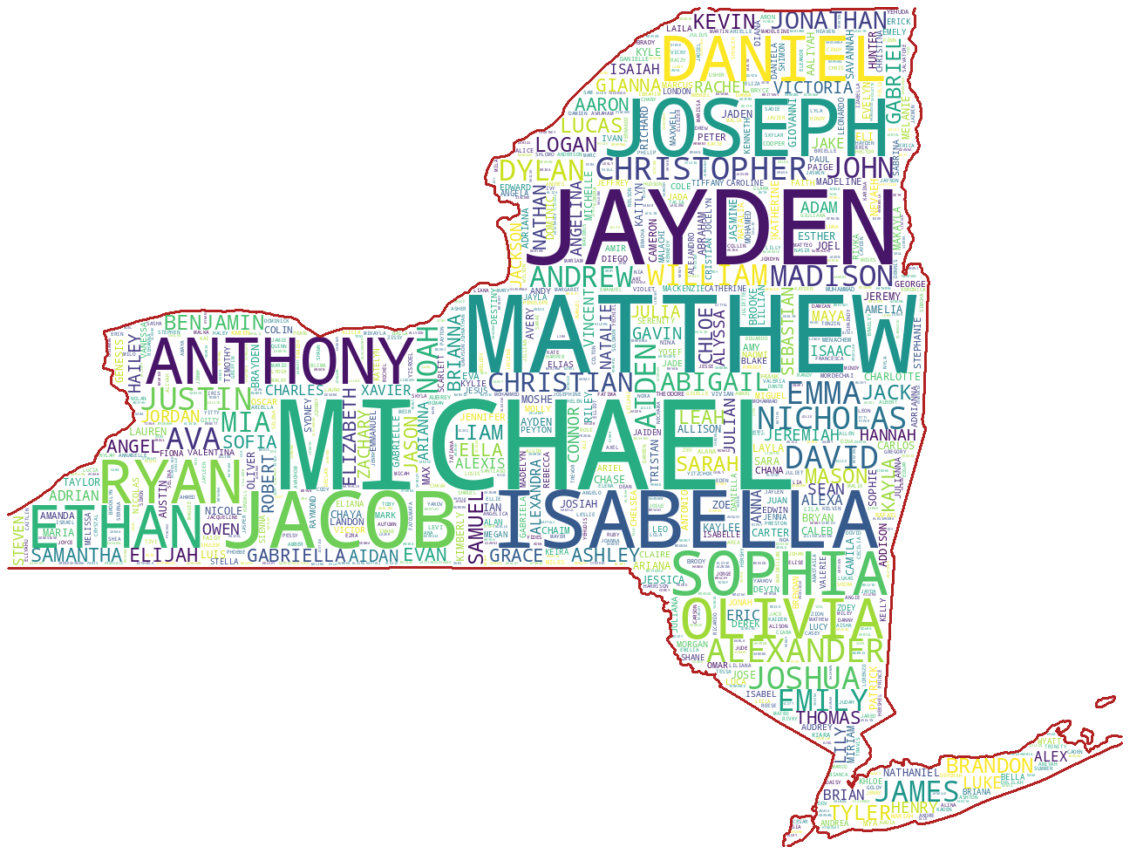

In [14]:
# Get name frequencies
grouped_name = baby_name_merged.groupby('First Name').agg({'Count':sum})
frequencies = grouped_name['Count'].to_dict()

# Creation of a mask from a map of NY State
ny_mask = np.array(Image.open('../img/1280px-Map_of_New_York_County_Outlines.svg.png'))
transformed_ny_mask = np.ndarray((ny_mask.shape[0],ny_mask.shape[1]), np.int32)
for i in range(len(ny_mask)):
    transformed_ny_mask[i] = [255 if y==0 else y for y in transformed_ny_mask[i]]

# Number of names to show
max_words = 1000
# Creation of the word cloud, big enough to see smaller names
wordcloud = WordCloud(background_color="white", max_words=max_words, mask=transformed_ny_mask,
                      contour_width=3, contour_color='firebrick')
wordcloud.generate_from_frequencies(frequencies=frequencies)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I'm particularly fond of this image, as it allows us to frame the problematic clearly putting NY State in the middle of the scene, as well as bombs our brains with key names to remember. It is easy to see here that Michael, Matthew, Jayden and Isabella are our top names, as well as differentiate, for instance, than Daniel is far more common than Nathan.

##### Occurrence by Year - Top 50 each Year

After acquiring a general idea of the presence of the different names among the births in NY State from 2008 and 2012 we may spatiate these years and see how the popularity of the top 50 names of each year evolve through time:

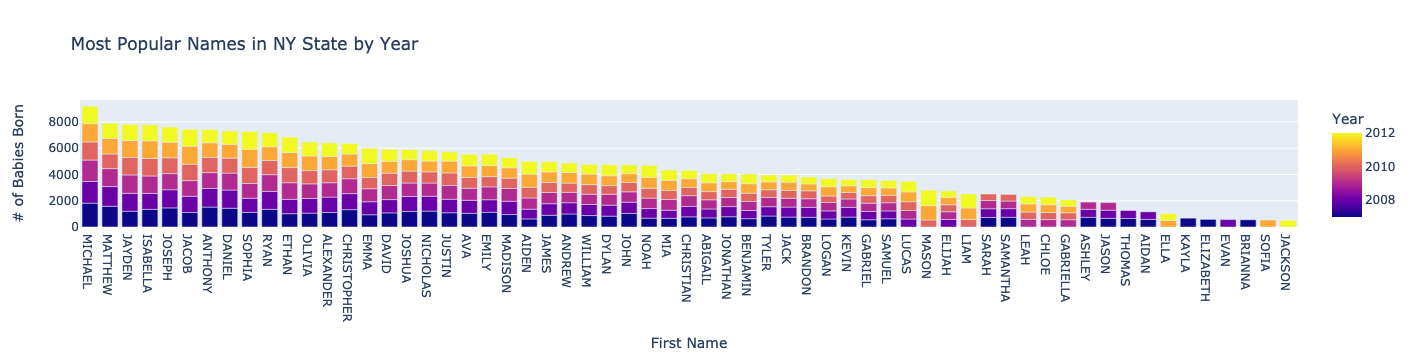

In [15]:
# Grouping names occurrences by Year, leaving only top 50 names of each year
stg_agg = baby_name_merged.groupby(['Year','First Name']).agg({'Count':sum})
grouped_year_name = stg_agg['Count'].groupby('Year', group_keys=False)
top50_year_name = grouped_year_name.nlargest(50).reset_index()

# List to order xaxis by top names
ordered_array = top50_year_name.groupby('First Name').sum().sort_values(ascending=False, by='Count').index

# Plotting information
fig2 = px.bar(data_frame=top50_year_name, x='First Name', y='Count', color='Year',
              title='Most Popular Names in NY State by Year')
fig2.update_yaxes(title='# of Babies Born')
fig2.update_layout(barmode='stack',
                   xaxis={'categoryorder':'array',
                          'categoryarray':ordered_array})

We see that there are some names that have a high and constant popularity through the years, such as Michael, Matthew or Isabella, whilst other top names have been introduced lately and strongly (such as Mason or Liam, maybe due to the fame of [Liam Hemsworth around 2010](https://es.wikipedia.org/wiki/Liam_Hemsworth)). On the other hand, names as Jason, Thomas or Aidan lost their place around the top 50 names of recent years, therefore losing representability across the state. 

#### Most Present Origin

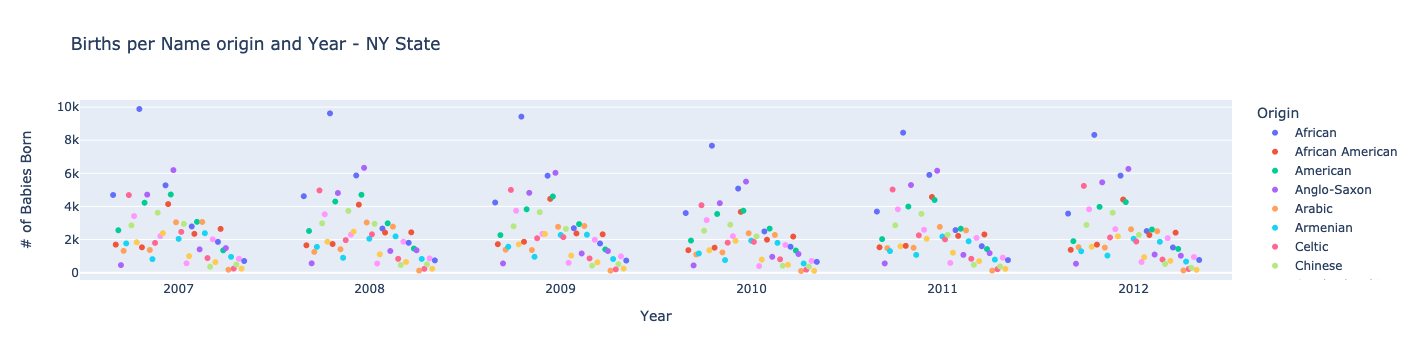

In [16]:
agg_year_origin = baby_name_merged.groupby(['Year', 'Origin']).agg({'Count': sum}).reset_index()

fig3 = px.strip(agg_year_origin, x='Year', y="Count", color='Origin',
                title='Births per Name origin and Year - NY State')
fig3.update_yaxes(title='# of Babies Born')
fig3.show()

What we see at first glance is that the distribution of name origins has not change drastically from 2008 to 2012, being quite stable in proportion during this time.

We see that across all the years the most predominant origin was the `Dutch`, being by far the most popular in NY State (around 8-10K babies named per year). `Irish` and `Hindi` names are also quite popular, whilst origins such as `Swahili` or `Welsh` are not popular at all across new yorkers.

### Analysis By County

#### Most Common Names

After taking a look at the distribution of each name at a state level we may now deep dive into their distribution per county. As we said, there are 1559 distinct names and 61 distinct counties in our dataset, which creates a need to summarize the information in a way that we don't saturate the user with thousands of bars or lines. For this reason, we are going to apply two different approaches: A chloropleth map with the most common name per county and a bar chart to represent how each county contributes to the top 100 names of NY State.

##### Chrolopleth Map

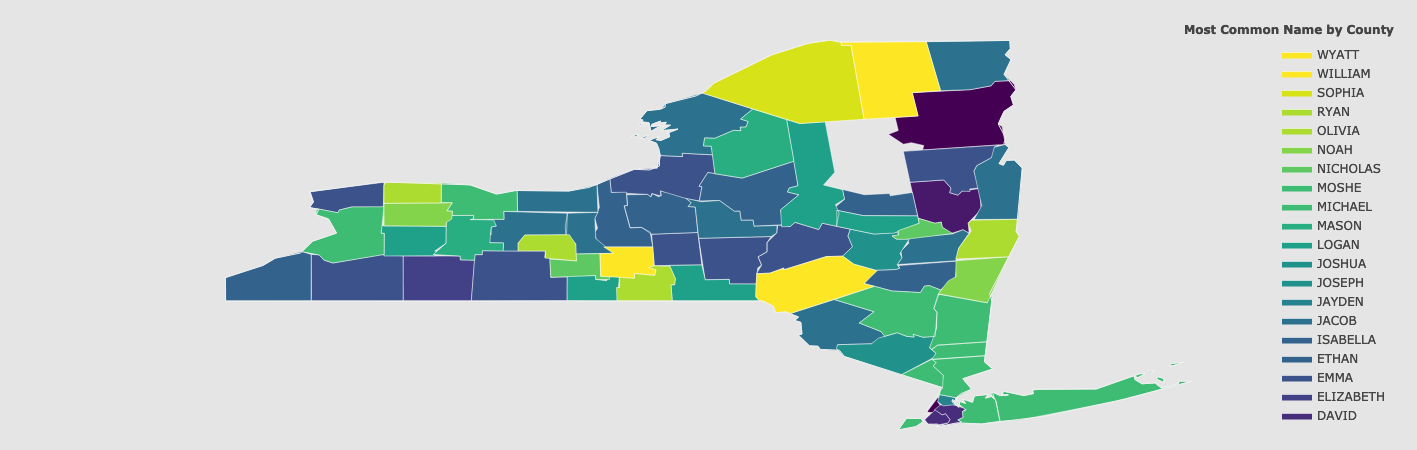

In [17]:
# Getting most common name per county
stg_agg = baby_name_merged.groupby(['County', 'First Name']).agg({'Count': sum})
grouped_by_name_county = stg_agg['Count'].groupby('County', group_keys=False)
top_name_county = grouped_by_name_county.nlargest(1).reset_index()

# Getting data about each county in the US from an external source
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties_df = pd.DataFrame([c['properties'] for c in counties['features']])
counties_df['NAME'] = counties_df['NAME'].str.upper()
# Getting its FIPS ID
counties_df['FIPS'] = counties_df['STATE'] + counties_df['COUNTY']
# Filtering by only the state of NY to avoid duplicate names
f = counties_df['STATE'] == '36'
filt_counties_df = counties_df[f]
# Changing ST. LAWRENCE to ST LAWRENCE to improve merging of both DFs
filt_counties_df['NAME'] = filt_counties_df['NAME'].str.replace('ST. LAWRENCE', 'ST LAWRENCE')

# Merging both data sources
fips_top_names = top_name_county.merge(filt_counties_df, left_on='County', right_on='NAME', how='inner')

# Plotting our map
fig4 = get_choropleth_categories(fips_top_names, 'First Name',
                                 'Most Common Name by County')
fig4.show()

As we introduced before, there is no information from 1 of the counties of NY, and that is [Hamilton](https://es.wikipedia.org/wiki/Condado_de_Hamilton_(Nueva_York). Apart from this particular issue, we've been able to plot a very useful map that shows clearly the presence of the top names across counties, being particularly important names as Michael, Isabella or Jacob.

##### Top 50 names' presence across counties

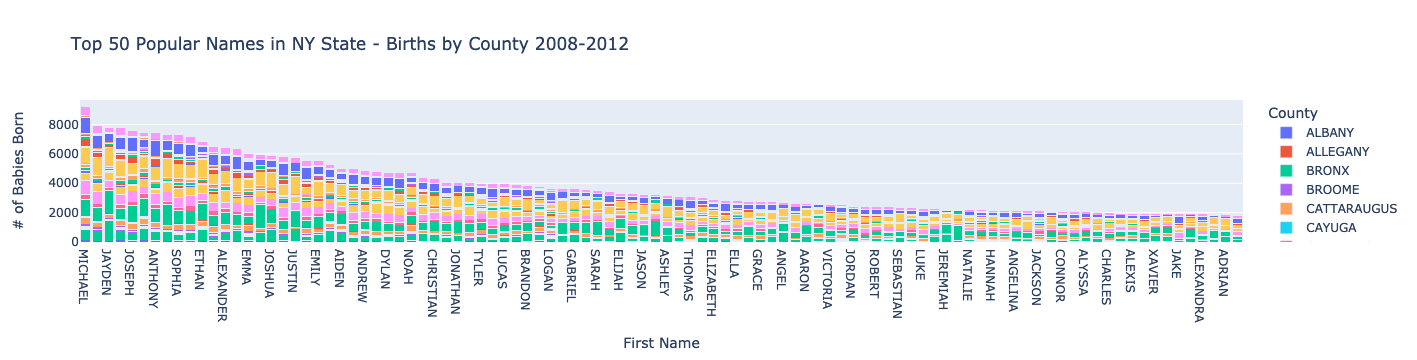

In [18]:
# Grouping names occurrences, leaving only top 50 names
grouped_name = baby_name_merged.groupby('First Name').agg({'Count':sum})
top50_names = grouped_name.nlargest(100, columns=['Count']).index

# Filtering only those names
f = baby_name_merged['First Name'].isin(top50_names)
top50_names_counties = baby_name_merged[f].groupby(['County', 'First Name']).agg({'Count':sum}).reset_index()

# Plotting information
fig5 = px.bar(data_frame=top50_names_counties, x='First Name', y='Count', color='County',
              title='Top 50 Popular Names in NY State - Births by County 2008-2012')
fig5.update_yaxes(title='# of Babies Born')
fig5.update_layout(barmode='stack',
                   xaxis={'categoryorder':'array',
                          'categoryarray':top50_names})
fig5.show()

In this visualization we see clearly the top 50 names of our dataset, as well as their diversity across counties. Some names as Michael are well spread, whilst others as Jonathan are far more common on regions such as Kings or Queens, showing off a predominant place on those states.

#### Most Present Origin

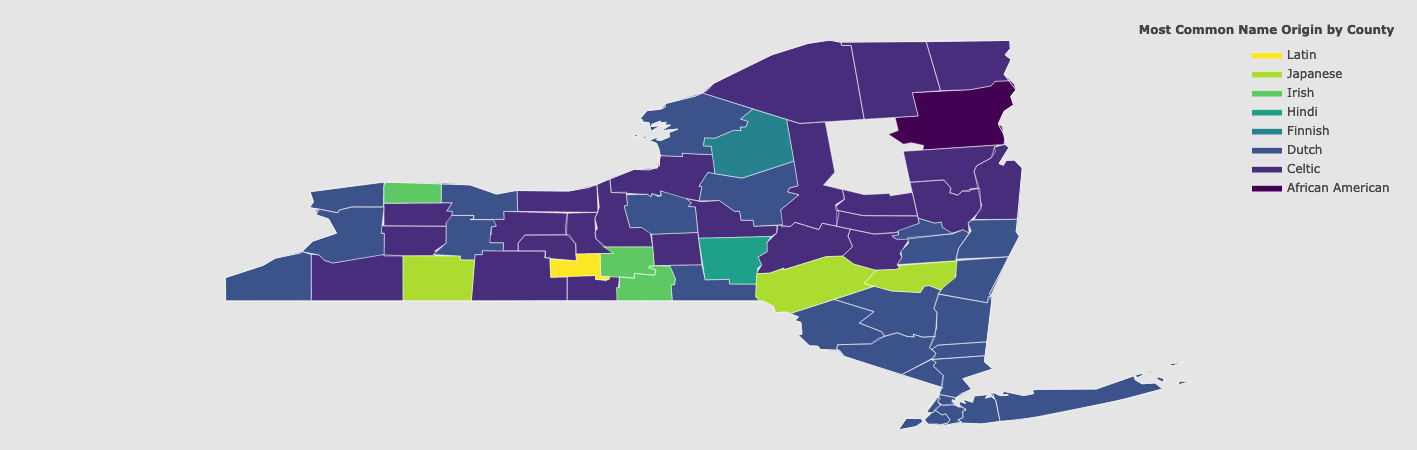

In [19]:
# Getting most common name per county
stg_agg = baby_name_merged.groupby(['County', 'Origin']).agg({'Count': sum})
grouped_by_origin_county = stg_agg['Count'].groupby('County', group_keys=False)
top_origin_county = grouped_by_origin_county.nlargest(1).reset_index()

# Merging both data sources
fips_top_origin = top_origin_county.merge(filt_counties_df, left_on='County', right_on='NAME', how='inner')

# Plotting our map
fig6 = get_choropleth_categories(fips_top_origin, 'Origin',
                                 'Most Common Name Origin by County')
fig6.show()

That last map was far more concise that the one we saw earlier analyzing the most common names in each county, therefore even though names tend to be more versatile and different, their origins usually collide among the most popular ones.

Thanks to this graph we may also see some possible migratory movements, as we clearly see that the south-eastern part of the state is dominated by Dutch names, the northern and central part by Celtic names and some residual counties have some influence from more residual cultures in the state such as Japanese or Irish ones. Therefore, I particularly liked this map much more than the one about names occurrences, as it provides us more subtle information.

### Most Representative County

To link county and state distribution of numbers we are taking two approaches:
1. We are going to represent which county has the more births and, therefore, is more important per the NY State distribution
2. We are checking which county's distribution is more similar to that of the state, by calculating a simple metric of distance ([Jaccard Similarity](https://es.wikipedia.org/wiki/%C3%8Dndice_Jaccard)) comparing top N names

#### Most Births per County

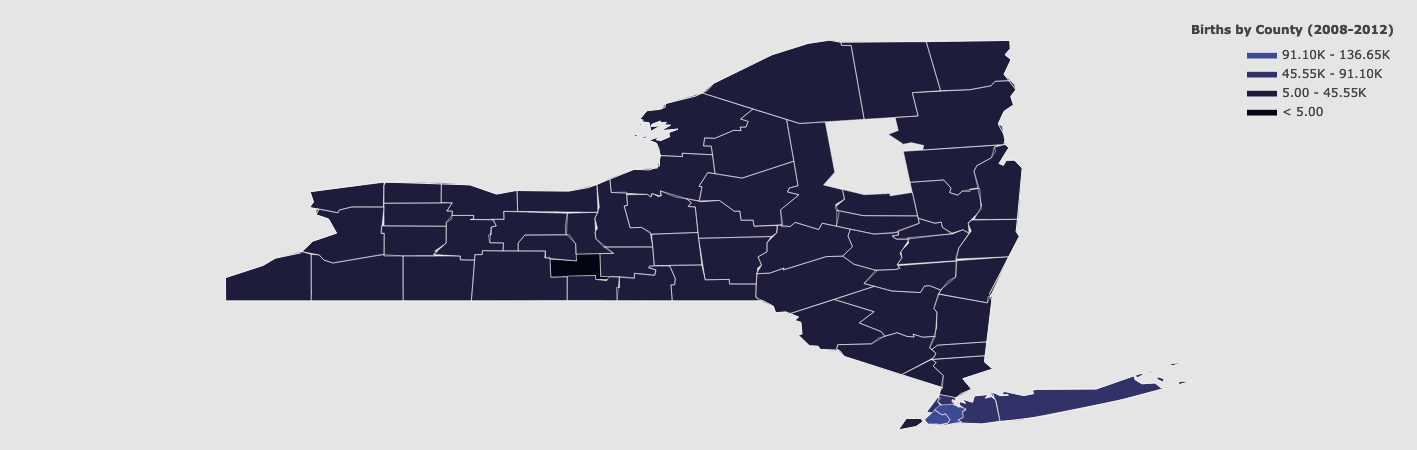

In [20]:
# Getting info of births per county and completing it with our geolocation data
grouped_x_county = baby_name_merged.groupby(['County']).agg({'Count': sum}).reset_index()
births_x_county = grouped_x_county.merge(filt_counties_df, left_on='County', right_on='NAME', how='inner')

# Plotting our map
fig7 = get_choropleth_numerical(births_x_county, 'Count',
                                'Births by County (2008-2012)')
fig7.show()

Here we see that one particular county (`SCHUYLER`) only provided 5 births to the state of NY, which most probably is an error due to bad data loading or handling.

Apart from this fact, we see that south-eastern counties are the ones with most births, being our top 3 {QUEENS, KINGS, SUFFOLK}, which is quite normal [being these 3 states among the top 4 more populated](https://www.newyork-demographics.com/counties_by_population).

#### Most Similar County

In [21]:
# Function to calculate Jaccard Distance
def jaccard_similarity(list1: list, list2: list) -> float:
    """ Calculates the jaccard distance between two collections
    
    :param list1: First list
    :param list2: Second list
    :return: Float representing the distance
    """
    
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    
    return float(intersection) / union


# Function to retrieve a Series with each county distance
def get_jaccard_series(names_x_county:pd.DataFrame, names_global:pd.DataFrame, top_n:int=0) -> pd.Series:
    """ Return a Pandas' Series with the jaccard similarity between each county and the state of NY
    
    :param list_county: Dataframe of names by occurrence of the county
    :param list_global: Dataframe of names by occurrence of the state of NY
    :param top_n: Number of occurrencies of the list to consider (top to bottom sorted)
    :return: Pandas' Series with most similar counties to the top of the state
    """
    # Dict to save results
    jaccard_distances = dict()
    
    # Iter by each county getting its list
    for county in names_x_county['County'].unique():
        f = names_x_county['County'] == county
        names_county = names_x_county[f].sort_values(by='Count', ascending=False)
        
        # If top_n is provided then filter by that number of rows
        if top_n>0:
            names_filtered = names_county.iloc[:top_n, 1]
            names_global_filtered = names_global.iloc[:top_n, 0]
        else:
            names_filtered = names_county.index
            names_global_filtered = names_global.index
        
        # Calculating the distance
        jaccard = jaccard_similarity(names_global_filtered, names_filtered)
        # Saving it into the dict
        jaccard_distances[county] = jaccard
        
    return pd.Series(jaccard_distances).sort_values(ascending=False)


# Function if we want to retrieve more than 1 range of top_n
def get_jaccard_dataframe(names_x_county:pd.DataFrame, names_global:pd.DataFrame, top_n_list:list) -> pd.DataFrame:
    """ Return a Pandas' DataFrame with the jaccard similarity between each county and the state of NY
    
    :param list_county: Dataframe of names by occurrence of the county
    :param list_global: Dataframe of names by occurrence of the state of NY
    :param top_n_list: Number of occurrencies of the list to consider (top to bottom sorted)
    :return: Pandas' DataFrame with Jaccard distances between NY and its counties for most popular names
    """
    # DF where to store the results
    final_df = pd.DataFrame()
    
    # Iter every value
    for n in top_n_list:
        stg_df = get_jaccard_series(names_x_county, names_global, n).reset_index()
        stg_df.columns = [
            'County',
            f'Jaccard Top {n}'
        ]
        if final_df.shape[0] == 0:
            final_df = stg_df
        else:
            final_df = final_df.merge(stg_df, on='County')
            
    return final_df

##### Top N Evolution 

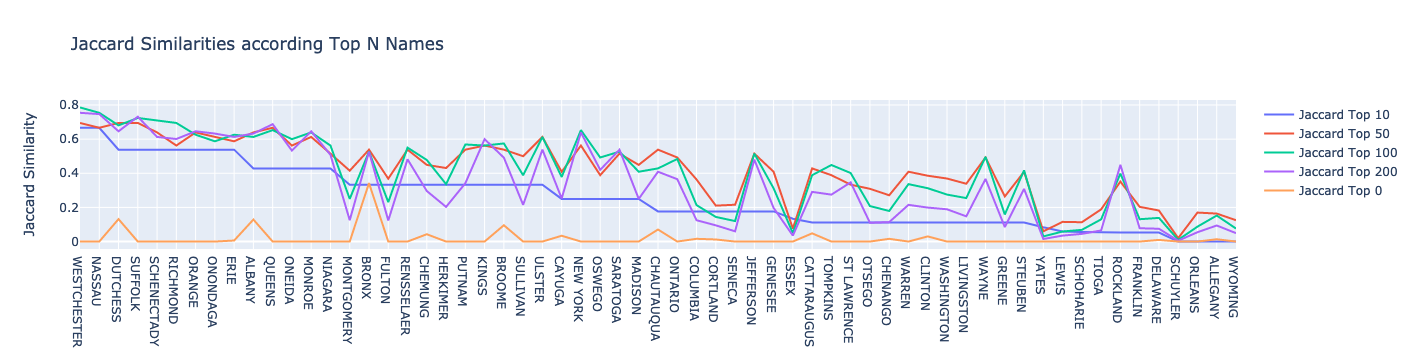

In [22]:
# Retrieving name occurrences per county and in global
names_x_county = baby_name_merged.groupby(['County', 'First Name']).agg({'Count': sum}).reset_index()
names_global = baby_name_merged.groupby('First Name').agg({'Count': sum}).reset_index().sort_values(by='Count', ascending=False)

# Retrieving the jaccard distance of the top 10, 50, 100 and 200 names
top_n_to_retrieve = [10, 50, 100, 200, 0]
jaccard_dataframe = get_jaccard_dataframe(names_x_county, names_global, top_n_to_retrieve)

# Plotting the results
fig8 = make_subplots()

# One line per Jaccard Scoring
for n in top_n_to_retrieve:
    fig8.add_trace(
        go.Scatter(x=jaccard_dataframe.County, y=jaccard_dataframe[f'Jaccard Top {n}'], name=f'Jaccard Top {n}')
    )
fig8.update_layout(title="Jaccard Similarities according Top N Names")
fig8.update_yaxes(title_text="Jaccard Similarity")
fig8.show()

##### Choropleth Top 100

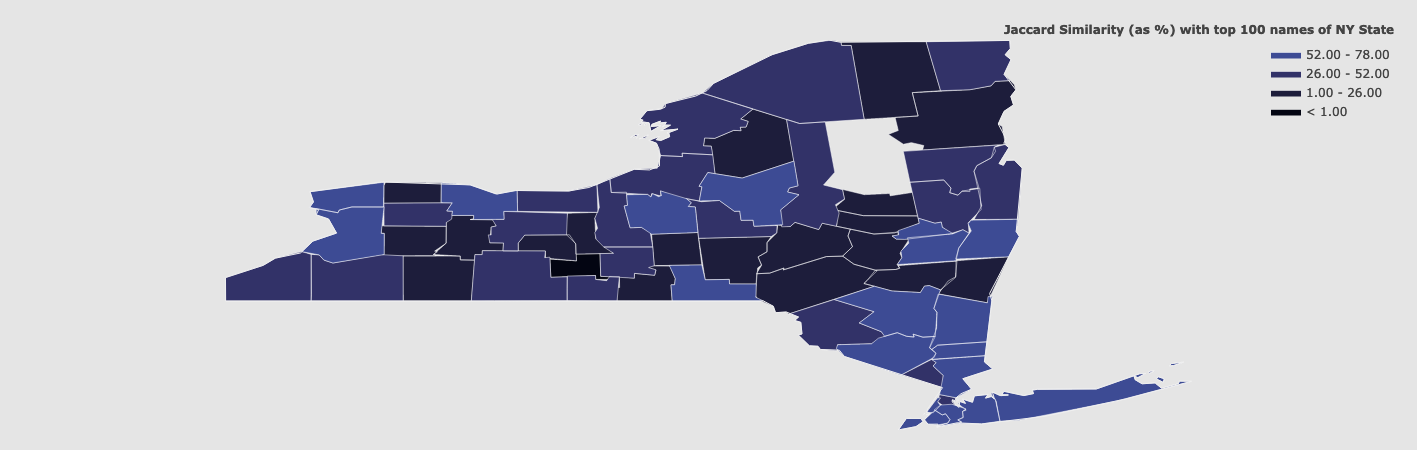

In [23]:
# Getting info of births per county and completing it with our geolocation data
jaccard_x_county = jaccard_dataframe.merge(filt_counties_df, left_on='County', right_on='NAME', how='inner')
# Disregarding 0 similarity counties to avoid problems while displaying map
f = jaccard_x_county['Jaccard Top 100'] > 0
jaccard_x_county = jaccard_x_county[f]
# Put the scorings in base 100 in order to be easier to read on the map
jaccard_x_county.iloc[:, 1:6] = jaccard_x_county.iloc[:, 1:6]*100

# Plotting our map
fig9 = get_choropleth_numerical(jaccard_x_county, 'Jaccard Top 100',
                                'Jaccard Similarity (as %) with top 100 names of NY State')
fig9.show()

Looking at our line chart, we see some powerful data at first glance. The one I liked the most is that the county of `Bronx` have a global similarity of .33, meaning that 33% of the names present during the births of 2008-2012 in NY State were present on that county, **therefore representing the most names present in the NY State**. Looking at different Top N of names subset, we infer that this may be due to a good variety of names inside that county, because it is far of the similarity of counties as `Westchester` or `Nassau` on top names. These last counties, then, **represent the most common names in the state**, which is also a good measure of similarity and we should take this into account.


If we take a look at the top 100 names of both counties and NY State as a whole, we see clearly on the map that that these insights are correct and there are some counties that tend to be much more complient with the state trend tahn others. This is the case of `Westchester` or `Nassau`, as I introduced earlier.

## Conclusions and Main Insights

After doing some digging into our data, we perceived so many curious facts about it. This exercise of analysis invited us to provide some correlation between the names' distribution of the whole state of NY and their counties, and we saw that the Bronx represents 1 third of the whole spectrum of names of the state. Nevertheless, if we were looking at the problem as the distribution of the most common names only (and thus the most representative per se), we noticed that Westchester had a similarity of 78% between its top 100 names and those of the state. Although, none of these counties represent the one that supplies more births to the NY state, as the top 3 are Queens, Kings and Suffolk, which are not specially relevant on the names' distribution per se.

While looking at the data we also feel the impulse to perform some research on the origins of the different names presented in the dataset. We analyzed those origins and conclude that the distribution of origins is almost constant through the years, but it depends greatly on the geographic scale. For instance, even though the Dutch names are the most present across the state and Dutch is the most popular origin on overpopulated states such as Kings, Queens and Suffolk, there are some counties that cluster names of different origins, like Delaware and Greene with Japanese names. This may be due to migratory fluxes and nation-based neighbourhoods (like the famous Chinatown) that make people of the same origins to gather around a certain county.

Apart from these conclusions, which accompanied with their correspondent visualizations may answer most of the exercise proposed, I noted some certain points that we may discuss. For instance, the distribution of the names' ocurrences through the years infer some demographic changes, such as the economical crisis that hit the hardest in 2010 on NY. Also, we saw how the appearance of media stars such as Liam Hemsworth inspire people to name their babies such those people. Also, we saw that even though boys have a higher set of names during the dataset, their baby names tend to be more concentrated on the top than those of the girls. This fact, combined with a ratio boys/girls higher than the national average, make the boy names to appear much more often on the top names (8 out of 10 top names are for boys).

This kind of analysis may interest a company that would like to launch a cultural product on NY state and would like the younger audiences to emphatize with a certain character by naming them as one of the most common names. Also, the name origins per county could be useful to understand better the demographic origins of the area and thus know which kind of cultures to reference in order to gain more engagement.